# Sextortion Investigation Demo

In this demo we will investigate Bitcoin addresses that received money from Sextortion Spam victims. The data from this demo is taken from our study [Spams meet Cryptocurrencies: Sextortion in the Bitcoin Ecosystem](https://arxiv.org/abs/1908.01051) and is a subset of [all the 12,533 Bitcoin addresses](https://github.com/MatteoRomiti/Sextortion_Spam_Bitcoin) we have collected from 4,340,736 sextortion spam emails.

The data for this demo is available in `./examples/data/sextortion_addresses.json`

We are going to answer the following questions:

* Q1: How many USD did the input addresses receive in total?

* Q2: How many USD did the corresponding entities receive in total?

* Q3: How many addresses are controlled by these entities?

* Q4: Where did the money come from, where did it go to?

* Q5: Can we find any known entities (e.g., exchanges) in the digital money trace?

## Preparations

First, we install the graphsense-python package as described in the [README](https://github.com/graphsense/graphsense-python/blob/master/README.md) of this repository. Import the package and configure the API endpoint. An API key for the public GraphSense demo API can be requested by sending an email to contact@graphense.info.

In [1]:
import graphsense
from graphsense.api import addresses_api, blocks_api, entities_api, general_api, bulk_api

import json

from pprint import pprint

In [2]:
configuration = graphsense.Configuration(
    host = "https://api.graphsense.info",
    api_key = {'api_key': 'YOUR_API_KEY'})

GraphSenes supports several asset types: Bitcoin (BTC), Bitcoin Cash (BCH), Litecoin (LTC), ZCash (ZEC).

We are investigating Bitcoin transactions, therefore we set the default currency to Bitcoin **BTC**.

In [3]:
CURRENCY = 'btc'

We can test whether or client works, by checking what data the GraphSense endpoint provides

In [4]:
with graphsense.ApiClient(configuration) as api_client:
    api_instance = general_api.GeneralApi(api_client)
    api_response = api_instance.get_statistics()
    pprint(api_response)

{'currencies': [{'name': 'btc',
                 'no_address_relations': 5803069891,
                 'no_addresses': 898424125,
                 'no_blocks': 708706,
                 'no_entities': 414664805,
                 'no_labels': 512,
                 'no_txs': 684867853,
                 'timestamp': 1636329501},
                {'name': 'eth',
                 'no_address_relations': 413798565,
                 'no_addresses': 198661753,
                 'no_blocks': 13585212,
                 'no_entities': 0,
                 'no_labels': 7700,
                 'no_txs': 1353041438,
                 'timestamp': 1636502398},
                {'name': 'zec',
                 'no_address_relations': 90503845,
                 'no_addresses': 6371561,
                 'no_blocks': 1462779,
                 'no_entities': 3141855,
                 'no_labels': 2,
                 'no_txs': 9533372,
                 'timestamp': 1637107185}],
 'request_timestamp': '2021-11-18 1

Now we load the provided sample Bitcoin addresses


In [5]:
INPUT_FILE = './data/sextortion_addresses.json' # 245 sextortion addresses
with open(INPUT_FILE, 'r') as fp:
    input_addresses = json.load(fp)
    
pprint(f"Example address: {input_addresses[0]}")
print(f"Total number of addresses: {len(input_addresses)}")

'Example address: 1JwRp2J8bQcoG8XTUbxQZaEj9QB4RB6zEa'
Total number of addresses: 245


# Q1. How many USD (US dollars) did the input addresses receive in total?

In [6]:
with graphsense.ApiClient(configuration) as api_client:
    api_instance = bulk_api.BulkApi(api_client)
    # Retrieve all addresses in bulk
    addresses = api_instance.bulk_json(CURRENCY, 
                                       operation='get_address',
                                       num_pages=1,
                                       body={'address':input_addresses})

In [7]:
fiat_values = [fv['value'] 
               for el in addresses 
               for fv in el['total_received_fiat_values'] 
               if fv['code'] == 'usd']
total_received = sum(fiat_values)
print("{} addresses received {:,.2f} USD".format(len(addresses), total_received))

245 addresses received 882,341.52 USD


# Q2: How many USD did the corresponding entities receive in total?
# Q3: How many addresses are controlled by these entities?

For each address, fetch the corresponding entity and store it in a dict for further use

In [8]:
address_entity = dict()  # address, entity_id
entities = dict()  # entity_id, details (for later)

In [9]:
with graphsense.ApiClient(configuration) as api_client:
    api_instance = bulk_api.BulkApi(api_client)
    # Retrieve all entities in bulk
    entities_list = api_instance.bulk_json(CURRENCY, 
                                           operation='get_address_entity',
                                           num_pages=1,
                                           body={'address':input_addresses})
  
for e in entities_list:
    entities[int(e['entity'])] = e

Count the number of retrieved entities, the number of addresses controlled by these entities, and sum up the total number of USD received by these entities

In [10]:
n_addresses = 0
usd_in = 0
for v in entities:
    n_addresses += entities[v]['no_addresses']
    for fv in entities[v]['total_received_fiat_values']:
        if fv['code'] == 'usd':
            usd_in += fv['value']

print("{} entities with {:,.0f} addresses received {:,.0f} USD".format(len(entities), n_addresses, usd_in))

96 entities with 1,940,357 addresses received 11,983,021,508 USD


Investigate these entities by plotting a histogram.

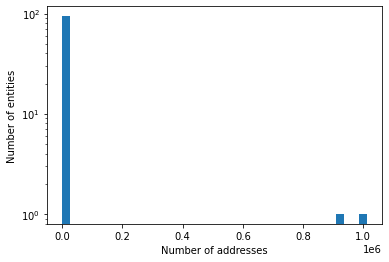

In [11]:
import matplotlib.pyplot as plt

#no_addresses_in_entities = [e for e in entities]
#no_addresses_in_entities

no_entity_addresses = [entity['no_addresses'] for entity in entities.values()]
plt.hist(no_entity_addresses, bins = 40)
plt.ylabel('Number of entities')
plt.xlabel('Number of addresses')
plt.yscale('log')
plt.show()

We can assume that entities with very large number of addresses are services (e.g., exchanges) or super-clusters. Therefore, for our further analysis, we filter our entities by **ignoring entities with more than 10K address**.

In [12]:
filtered_entities = [entity for entity in entities.values() if entity['no_addresses'] < 10000]

n_addresses = 0
usd_in = 0
for entity in filtered_entities:
    n_addresses += entity['no_addresses']
    for fv in entities[v]['total_received_fiat_values']:
        if fv['code'] == 'usd':
            usd_in += fv['value']
    
print("{} entities with {:,.0f} addresses received {:,.0f} USD"
      .format(len(filtered_entities), n_addresses, usd_in))

94 entities with 562 addresses received 65,694 USD


# Q4: Where did the money come from, where did it go to?

For all filtered entities we now gather all incoming and outgoing entities.

In [13]:
entity_nbrs_in = dict()
entity_nbrs_out = dict()

with graphsense.ApiClient(configuration) as api_client:
    api_instance = entities_api.EntitiesApi(api_client)
    for i, e in enumerate(filtered_entities):
        print(i+1, end='\r')
        if e['entity'] not in entity_nbrs_in:
            entity_nbrs_in[e['entity']] = api_instance.list_entity_neighbors(CURRENCY, int(e['entity']), 
                                                                          direction='in', include_labels=True)
        if e['entity'] not in entity_nbrs_out:
            entity_nbrs_out[e['entity']] = api_instance.list_entity_neighbors(CURRENCY, int(e['entity']),
                                                                           direction='out', include_labels=True)

To get an overview, we count the number of incoming and outgoing entities

In [14]:
no_incoming_entities = {key:len(entity_nbrs_in[key]['neighbors']) for key in entity_nbrs_in}

no_outgoing_entities = {key:len(entity_nbrs_out[key]['neighbors']) for key in entity_nbrs_out}

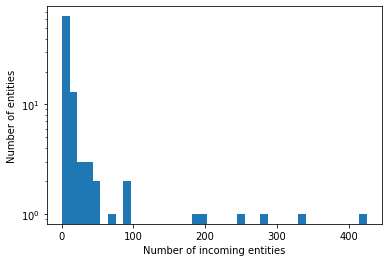

In [15]:
plt.hist(no_incoming_entities.values(), bins = 40)
plt.ylabel('Number of entities')
plt.xlabel('Number of incoming entities')
plt.yscale('log')
plt.show()

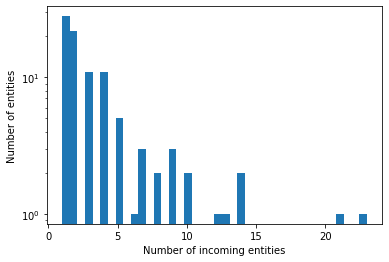

In [16]:
plt.hist(no_outgoing_entities.values(), bins = 40)
plt.ylabel('Number of entities')
plt.xlabel('Number of incoming entities')
plt.yscale('log')
plt.show()

## Q5: Can we find any known entities (e.g., exchanges) in the digital money trace?

In [17]:
# Collect IDs of those incoming entities that carry labels

known_incoming_entities = {}

for neighbors in entity_nbrs_in.values():
    for neighbor in neighbors['neighbors']:
        if len(neighbor['labels']) > 0:
            known_incoming_entities[int(neighbor['id'])] = neighbor['labels'][0]
            
pprint(known_incoming_entities)

{45198656: 'Bittrex.com',
 145208378: 'VirWoX.com',
 173054736: 'Xapo.com',
 338004169: 'Poloniex.com',
 407126516: 'Cubits.com',
 445900480: 'Bitstamp.net',
 525867568: 'Huobi.com',
 637504149: 'Cryptonator.com'}


In [18]:
# Collect IDs of those outoging entities that carry labels

known_outgoing_entities = {}

for neighbors in entity_nbrs_out.values():
    for neighbor in neighbors['neighbors']:
        if len(neighbor['labels']) > 0:
            known_outgoing_entities[int(neighbor['id'])] = neighbor['labels'][0]
            
pprint(known_outgoing_entities)

{488001697: 'CoinPayments.net', 637504149: 'Cryptonator.com'}


## Network Visualization

Finally, we build and visualize a network showing the entities we just identified and collected.

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

### Entities sending money to sextortion addresses

In [20]:
g = nx.DiGraph()
for (entity, neighbors) in entity_nbrs_in.items():
    for neighbor in neighbors.neighbors:
        if len(neighbor.labels) > 0:
            g.add_edge(neighbor.id, entity)
            g.add_node(entity, label='sextortion')
            if int(neighbor['id']) in known_incoming_entities:
                g.add_node(neighbor['id'], label=known_incoming_entities[int(neighbor['id'])])
            else:
                g.add_node(neighbor['id'], label='Unknown')                

In [21]:
print(f"Number of nodes: {g.number_of_nodes()}")
print(f"Number of edges: {g.number_of_edges()}")

Number of nodes: 40
Number of edges: 54


In [22]:
node_colours = []

for node_id, values in list(g.nodes(data=True)):
    if(values['label'] == 'sextortion'):
        node_colours.append('red')
    else:
        node_colours.append('green')

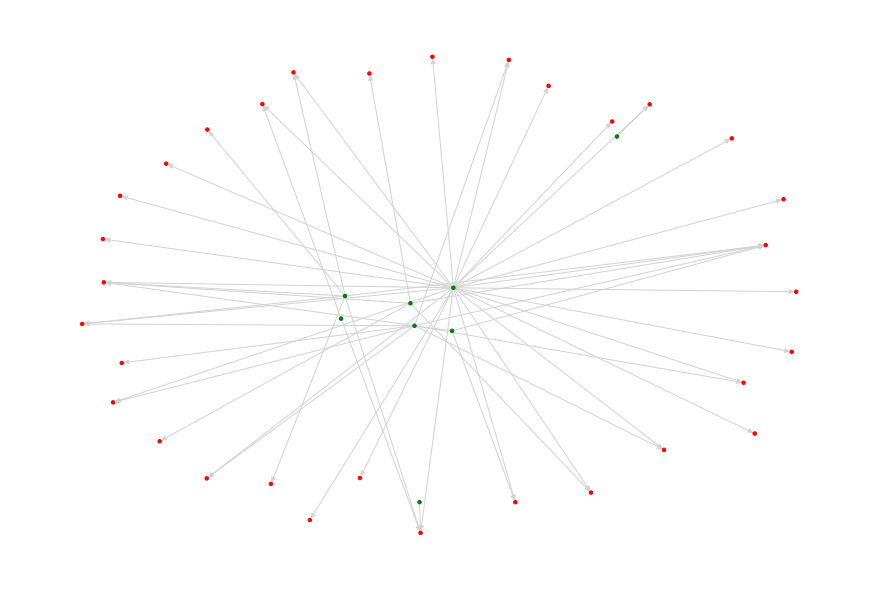

In [23]:
pos = nx.fruchterman_reingold_layout(g)
plt.figure(figsize=(12, 8))
plt.title.text = "Known entities sending money to addresses involved in sextortion spam."
nx.draw(g, 
        edge_color='lightgrey',
        node_color=node_colours,
        node_size=12,
        pos=pos)


### Entities receiving money from sextortion addresses

In [24]:
g = nx.DiGraph()
for (entity, neighbors) in entity_nbrs_out.items():
    for neighbor in neighbors.neighbors:
        if len(neighbor.labels) > 0:
            g.add_edge(neighbor.id, entity)
            g.add_node(entity, label='sextortion')
            if int(neighbor['id']) in known_outgoing_entities:
                g.add_node(neighbor['id'], label=known_outgoing_entities[int(neighbor['id'])])
            else:
                g.add_node(neighbor['id'], label='Unknown')                

In [25]:
print(f"Number of nodes: {g.number_of_nodes()}")
print(f"Number of edges: {g.number_of_edges()}")

Number of nodes: 4
Number of edges: 2


In [26]:
node_colours = []
label_dict = {}

for node_id, values in list(g.nodes(data=True)):
    if(values['label'] == 'sextortion'):
        node_colours.append('red')
    else:
        node_colours.append('green')
        label_dict[node_id] = node_id

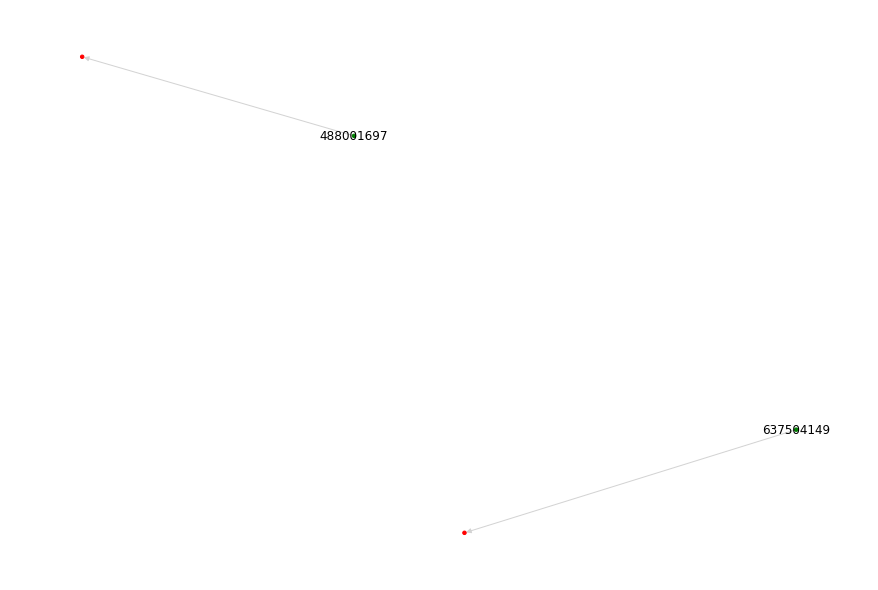

In [27]:
pos = nx.fruchterman_reingold_layout(g)
plt.figure(figsize=(12, 8))
plt.title.text = "Known entities sending money to addresses involved in sextortion spam."
nx.draw(g, 
        edge_color='lightgrey',
        node_color=node_colours,
        node_size=12,
        labels=label_dict,
        with_labels=True,
        pos=pos)
